<a href="https://colab.research.google.com/github/ozturkc/Financial-Network-Modeling-with-Graph-Neural-Networks/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Ortam Kurulumu ve Gerekli Kütüphanelerin Yüklenmesi

Bu hücrede, Google Colab ortamının GPU desteğini kontrol ediyoruz, çalışma dizinini ayarlıyoruz (örneğin, `/content` altına geçiş yapıyoruz) ve gerekli Python kütüphanelerini yüklüyoruz.


In [ ]:
# GPU kullanımı için ayar: GPU varsa kullan, yoksa CPU kullan
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Kullanılan cihaz:", device)

Kullanılan cihaz: cpu


# 1. Ortam Kurulumu ve Gerekli Kütüphanelerin Yüklenmesi

Bu hücrede, Google Colab ortamının GPU desteğini kontrol ediyoruz, çalışma dizinini ayarlıyoruz ve aşağıdaki projede kullanılacak kütüphaneleri yüklüyoruz.

**Matematiksel Açıklama:**
- GPU varsa hesaplamaları hızlandırmak için GPU cihazı kullanılır.
- Gerekli kütüphaneler arasında finansal veri çekmek için `yfinance`, grafik işlemleri için `networkx`, derin öğrenme için `torch` ve `torch-geometric`, hiperparametre optimizasyonu için `optuna` ve portföy optimizasyonu için `cvxpy` yer almaktadır.


In [ ]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Change working directory to a desired folder in your Drive
#    (Ensure that this folder path actually exists or create it beforehand)
os.chdir('/content/drive/MyDrive/GNN')

# 3. Verify current directory (optional)
print("Current working directory:", os.getcwd())

# Gerekli kütüphaneleri yükleyelim
!pip install yfinance torch-geometric optuna cvxpy --quiet


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/GNN


# 2. BİST30 Verilerinin yfinance ile Çekilmesi ve Hazırlanması

Bu hücrede, yfinance kullanılarak BİST30 hisse senetlerinin son 1 yıllık günlük kapanış fiyatları çekilir.  
Veriler temizlenir, eğitim ve test setlerine ayrılır ve günlük getiriler hesaplanır.

**Matematiksel Açıklama:**
- Fiyat verilerinden günlük getiriler; $( r_t = \frac{P_t - P_{t-1}}{P_{t-1}} )$ formülü ile hesaplanır.
- Eğitim ve test periyotları belirlenerek modelin geçmiş verilerle eğitilmesi ve geleceğe yönelik test edilmesi sağlanır.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# BİST30 hisse senetleri (Yahoo Finance üzerinde .IS eki ile)
tickers = [
    'AEFES.IS', 'AKBNK.IS', 'ALARK.IS', 'ASELS.IS', 'ASTOR.IS',
    'BIMAS.IS', 'EKGYO.IS', 'ENKAI.IS', 'EREGL.IS', 'FROTO.IS',
    'GARAN.IS', 'HEKTS.IS', 'ISCTR.IS', 'KCHOL.IS', 'KONTR.IS',
    'KOZAL.IS', 'KRDMD.IS', 'MGROS.IS', 'PETKM.IS', 'PGSUS.IS',
    'SAHOL.IS', 'SASA.IS', 'SISE.IS', 'TCELL.IS', 'THYAO.IS',
    'TOASO.IS', 'TTKOM.IS', 'TUPRS.IS', 'ULKER.IS', 'YKBNK.IS'
]

# Son 1 yılın günlük kapanış fiyatlarını indiriyoruz (auto_adjust ile fiyatlar düzeltiliyor)
data = yf.download(tickers, start="2014-01-01", end="2025-02-28", interval="1d", auto_adjust=True)
prices = data['Close']
prices.dropna(inplace=True)  # Eksik veriler kaldırılır

# Eğitim ve Test setlerini ayıralım:
train_size = int(len(prices) * 0.8)
train_data = prices.iloc[:train_size]
test_data = prices.iloc[train_size:]

# Günlük getirileri hesaplayalım

train_returns = train_data.pct_change().dropna()
test_returns = test_data.pct_change().dropna()

print("Veri çekimi ve hazırlama tamamlandı.")

[*********************100%***********************]  30 of 30 completed
<ipython-input-29-b64bb61330a1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices.dropna(inplace=True)  # Eksik veriler kaldırılır


Veri çekimi ve hazırlama tamamlandı.


# 3. Grafik Oluşturma: Hisse Senetleri Arası İlişkilerin Modelleme

Bu hücrede, eğitim getirileri üzerinden hisse getirilerinin korelasyon matrisi hesaplanır.  
Belirlenen eşik değerine göre (örneğin, 0.5) NetworkX kullanılarak bir grafik oluşturulur.  
Oluşturulan grafikte her bir düğüm bir hisseyi, kenarlar ise iki hisse arasındaki korelasyonu temsil eder.  
Düğüm isimleri (string) integer indekslere dönüştürülerek, PyTorch Geometric için `edge_index` oluşturulur.

**Matematiksel Açıklama:**
- Korelasyon matrisi \( C \) hesaplanır: $( C_{ij} = |\text{corr}(r_i, r_j)|)$.
- Belirli bir eşik değerinin üzerindeki korelasyonlar (ör. $ C_{ij} > 0.5 $) kenar olarak graf yapısına eklenir.
- Düğüm indeksleri, modelin hesaplamalarında kullanılmak üzere integer olarak atanır.


In [ ]:
import networkx as nx
import torch

# Hisse getirileri arası mutlak korelasyon matrisi hesaplanıyor
corr_matrix = train_returns.corr().abs()
threshold = 0.5  # Korelasyon eşiği

# NetworkX ile graf oluşturma: düğüm = hisse, kenar = korelasyon > eşik
G_nx = nx.Graph()
for ticker in prices.columns:
    G_nx.add_node(ticker)
for i, t1 in enumerate(prices.columns):
    for j, t2 in enumerate(prices.columns):
        if i < j and corr_matrix.loc[t1, t2] > threshold:
            G_nx.add_edge(t1, t2, weight=corr_matrix.loc[t1, t2])

# Düğüm isimlerini integer indekslere eşleyelim
node_to_idx = {node: idx for idx, node in enumerate(G_nx.nodes())}
edge_list = [(node_to_idx[u], node_to_idx[v]) for u, v in G_nx.edges()]

# PyTorch Geometric için edge_index oluşturma
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
print("Grafik oluşturma tamamlandı. edge_index şekli:", edge_index.shape)




Grafik oluşturma tamamlandı. edge_index şekli: torch.Size([2, 318])


# 4. GNN için Özelliklerin (Features) Oluşturulması

Bu hücrede, her hisse için eğitim verilerinden ortalama getiri ve volatilite hesaplanır.  
Bu iki özellik, modelin giriş verileri olarak kullanılacaktır.

**Matematiksel Açıklama:**
- Ortalama getiri: $ \mu_i = \frac{1}{T}\sum_{t=1}^{T} r_{i,t} $
- Volatilite: $ \sigma_i = \sqrt{\frac{1}{T-1}\sum_{t=1}^{T} (r_{i,t} - \mu_i)^2} $


In [ ]:
# Her hisse için ortalama getiri ve volatilite hesaplanıyor


features_list = []
for ticker in prices.columns:
    avg_ret = train_returns[ticker].mean()
    vol = train_returns[ticker].std()
    features_list.append([avg_ret, vol])
features = torch.tensor(features_list, dtype=torch.float)
features = (features - features.mean(dim=0)) / features.std(dim=0)  # Normalizasyon
print("Özellikler oluşturuldu. Şekil:", features.shape)

Özellikler oluşturuldu. Şekil: torch.Size([30, 2])


# 5. GCN Modelinin Geliştirilmesi: Dropout, Batch Normalization ve Projeksiyon Katmanı

Bu hücrede, GCN modelimizi geliştirmek için dropout ve batch normalization ekliyoruz.  
Ayrıca, modelin ikinci katmanından çıkan vektörlerin boyutunu giriş özellik boyutuna (2) indirecek bir projeksiyon katmanı ekleniyor.  
Bu sayede, modelin çıktısı MSELoss ile uyumlu hale gelir.

**Matematiksel Açıklama:**
- İlk GCN katmanı: $ h^{(1)} = \text{ReLU}(\text{BN}(A X W_1) $
- Dropout uygulanır: $ h^{(1)} = \text{Dropout}(h^{(1)}) $
- İkinci GCN katmanı: $ h^{(2)} = \text{ReLU}(\text{BN}(A h^{(1)} W_2) $
- Tekrar dropout uygulanır.
- Projeksiyon katmanı: $ \hat{X} = h^{(2)} W_p $ ve $ \hat{X} $ boyutu giriş özellikleri boyutuna (2) indirilir.


In [ ]:


class ImprovedGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, out_channels, dropout_rate=0.3):
        super(ImprovedGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels1)
        self.bn1 = nn.BatchNorm1d(hidden_channels1)
        self.conv2 = GCNConv(hidden_channels1, hidden_channels2)  # Ek katman
        self.bn2 = nn.BatchNorm1d(hidden_channels2)
        self.conv3 = GCNConv(hidden_channels2, out_channels)     # Ek katman
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        self.proj = nn.Linear(out_channels, in_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)  # Ek katman
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)  # Ek katman
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.proj(x)
        return x

print("Geliştirilmiş GCN modeli (3 katmanlı) tanımlandı.")

Geliştirilmiş GCN modeli (3 katmanlı) tanımlandı.


# 6. Hiperparametre Optimizasyonu (Optuna ile)

Bu hücrede, Optuna kullanarak ImprovedGCN modelimizin hiperparametrelerini optimize ediyoruz.  
Hiperparametre aralıklarına gizli katman boyutu, çıktı boyutu, dropout oranı, öğrenme oranı ve epoch sayısı dahildir.  
Objective fonksiyonu, modelin eğitim ve doğrulama aşamasındaki MSE kaybını minimize etmeye çalışır.

**Matematiksel Açıklama:**
- MSE Loss: $ L = \frac{1}{N}\sum_{i=1}^{N} \| \hat{x}_i - x_i \|^2 $
- Optimizasyonun amacı, $ \min L $ olacak hiperparametre kombinasyonunu bulmaktır.


In [ ]:
"""# 5. Hiperparametre Optimizasyonu
Optuna ile hiperparametreler optimize edilir. Tam veri seti kullanılır, alt küme ayrımı kaldırıldı.
"""

def objective(trial):
    hidden_channels1 = trial.suggest_int("hidden_channels1", 4, 64)
    hidden_channels2 = trial.suggest_int("hidden_channels2", 4, 32)  # Ek katman
    out_channels = trial.suggest_int("out_channels", 2, 16)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-1)
    epochs = trial.suggest_int("epochs", 50, 200)

    # Tam features kullanılır, alt küme ayrımı kaldırıldı
    model = ImprovedGCN(in_channels=2, hidden_channels1=hidden_channels1,
                        hidden_channels2=hidden_channels2, out_channels=out_channels,
                        dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(features.to(device), edge_index.to(device))  # Tam veri seti
        loss = criterion(out, features.to(device))
        loss.backward()
        optimizer.step()

    # Doğrulama kaybı da tam veri üzerinden hesaplanır
    model.eval()
    with torch.no_grad():
        out = model(features.to(device), edge_index.to(device))
        val_loss = criterion(out, features.to(device))
    return val_loss.item()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print("En iyi hiperparametreler:", study.best_trial.params)

[I 2025-03-04 21:02:29,708] A new study created in memory with name: no-name-ff0326f9-a0fd-4f31-b1bb-dce321711af9
<ipython-input-35-12004f5580b7>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-1)
[I 2025-03-04 21:02:30,390] Trial 0 finished with value: 0.2105134129524231 and parameters: {'hidden_channels1': 11, 'hidden_channels2': 11, 'out_channels': 12, 'dropout_rate': 0.22037991090101483, 'learning_rate': 0.006416807166790424, 'epochs': 148}. Best is trial 0 with value: 0.2105134129524231.
[I 2025-03-04 21:02:30,696] Trial 1 finished with value: 0.9475935101509094 and parameters: {'hidden_channels1': 33, 'hidden_channels2': 26, 'out_channels': 13, 'dropout_rate': 0.2397677096311661, 'learning_rate': 1.8101940656391828e-05, 'epochs': 51}. Best is trial 0 wit

En iyi hiperparametreler: {'hidden_channels1': 29, 'hidden_channels2': 23, 'out_channels': 16, 'dropout_rate': 0.10216198502698534, 'learning_rate': 0.013800359116283235, 'epochs': 152}


# 7. En İyi Hiperparametrelerle Final GCN Modelinin Eğitimi ve Eğitim-Test Loss Grafiğinin Çizdirilmesi

Bu hücrede, Optuna’dan elde edilen en iyi hiperparametrelerle final ImprovedGCN modelimizi eğitiyoruz.  
Eğitim sırasında, her epoch'ta hem eğitim (train) hem de test loss değerleri hesaplanır ve kaydedilir.  
Test verisi için, modelin aynı mimariden test özellikleri (ortalama getiri ve volatilite) üzerinden loss hesaplanır.  

**Matematiksel Açıklama:**

- **Eğitim Loss'u:**  
  $ L_{\text{train}} = \frac{1}{N}\sum_{i=1}^{N} \| \hat{x}_i - x_i \|^2 $  
  Burada $ \hat{x}_i $ modelin ürettiği embedding, $ x_i $ ise orijinal giriş özellikleridir (ortalama getiri ve volatilite).

- **Test Loss'u:**  
  Aynı MSE loss fonksiyonu, test setine uygulanır. Test özellikleri, eğitim özelliklerinin test verisi üzerinden hesaplanmış halidir.

Her epoch'ta eğitim ve test loss değerlerinin kaydedilmesi, modelin overfitting ya da underfitting durumunu gözlemlememize olanak tanır. Eğitim bitiminde, loss değerlerinin epoch'lara göre grafiksel gösterimi yapılır.



Epoch 2/152: Train Loss = 0.9782, Test Loss = 0.9668
Epoch 4/152: Train Loss = 0.9142, Test Loss = 0.9210
Epoch 6/152: Train Loss = 0.8552, Test Loss = 0.8954
Epoch 8/152: Train Loss = 0.8197, Test Loss = 0.8700
Epoch 10/152: Train Loss = 0.7520, Test Loss = 0.8029
Epoch 12/152: Train Loss = 0.6869, Test Loss = 0.7488
Epoch 14/152: Train Loss = 0.6043, Test Loss = 0.6953
Epoch 16/152: Train Loss = 0.5636, Test Loss = 0.6854
Epoch 18/152: Train Loss = 0.5600, Test Loss = 0.6711
Epoch 20/152: Train Loss = 0.5159, Test Loss = 0.6358
Epoch 22/152: Train Loss = 0.4611, Test Loss = 0.6032
Epoch 24/152: Train Loss = 0.4272, Test Loss = 0.6176
Epoch 26/152: Train Loss = 0.3931, Test Loss = 0.6351
Epoch 28/152: Train Loss = 0.3483, Test Loss = 0.6767
Epoch 30/152: Train Loss = 0.3021, Test Loss = 0.7362
Early stopping at epoch 32
Final GCN model eğitildi.


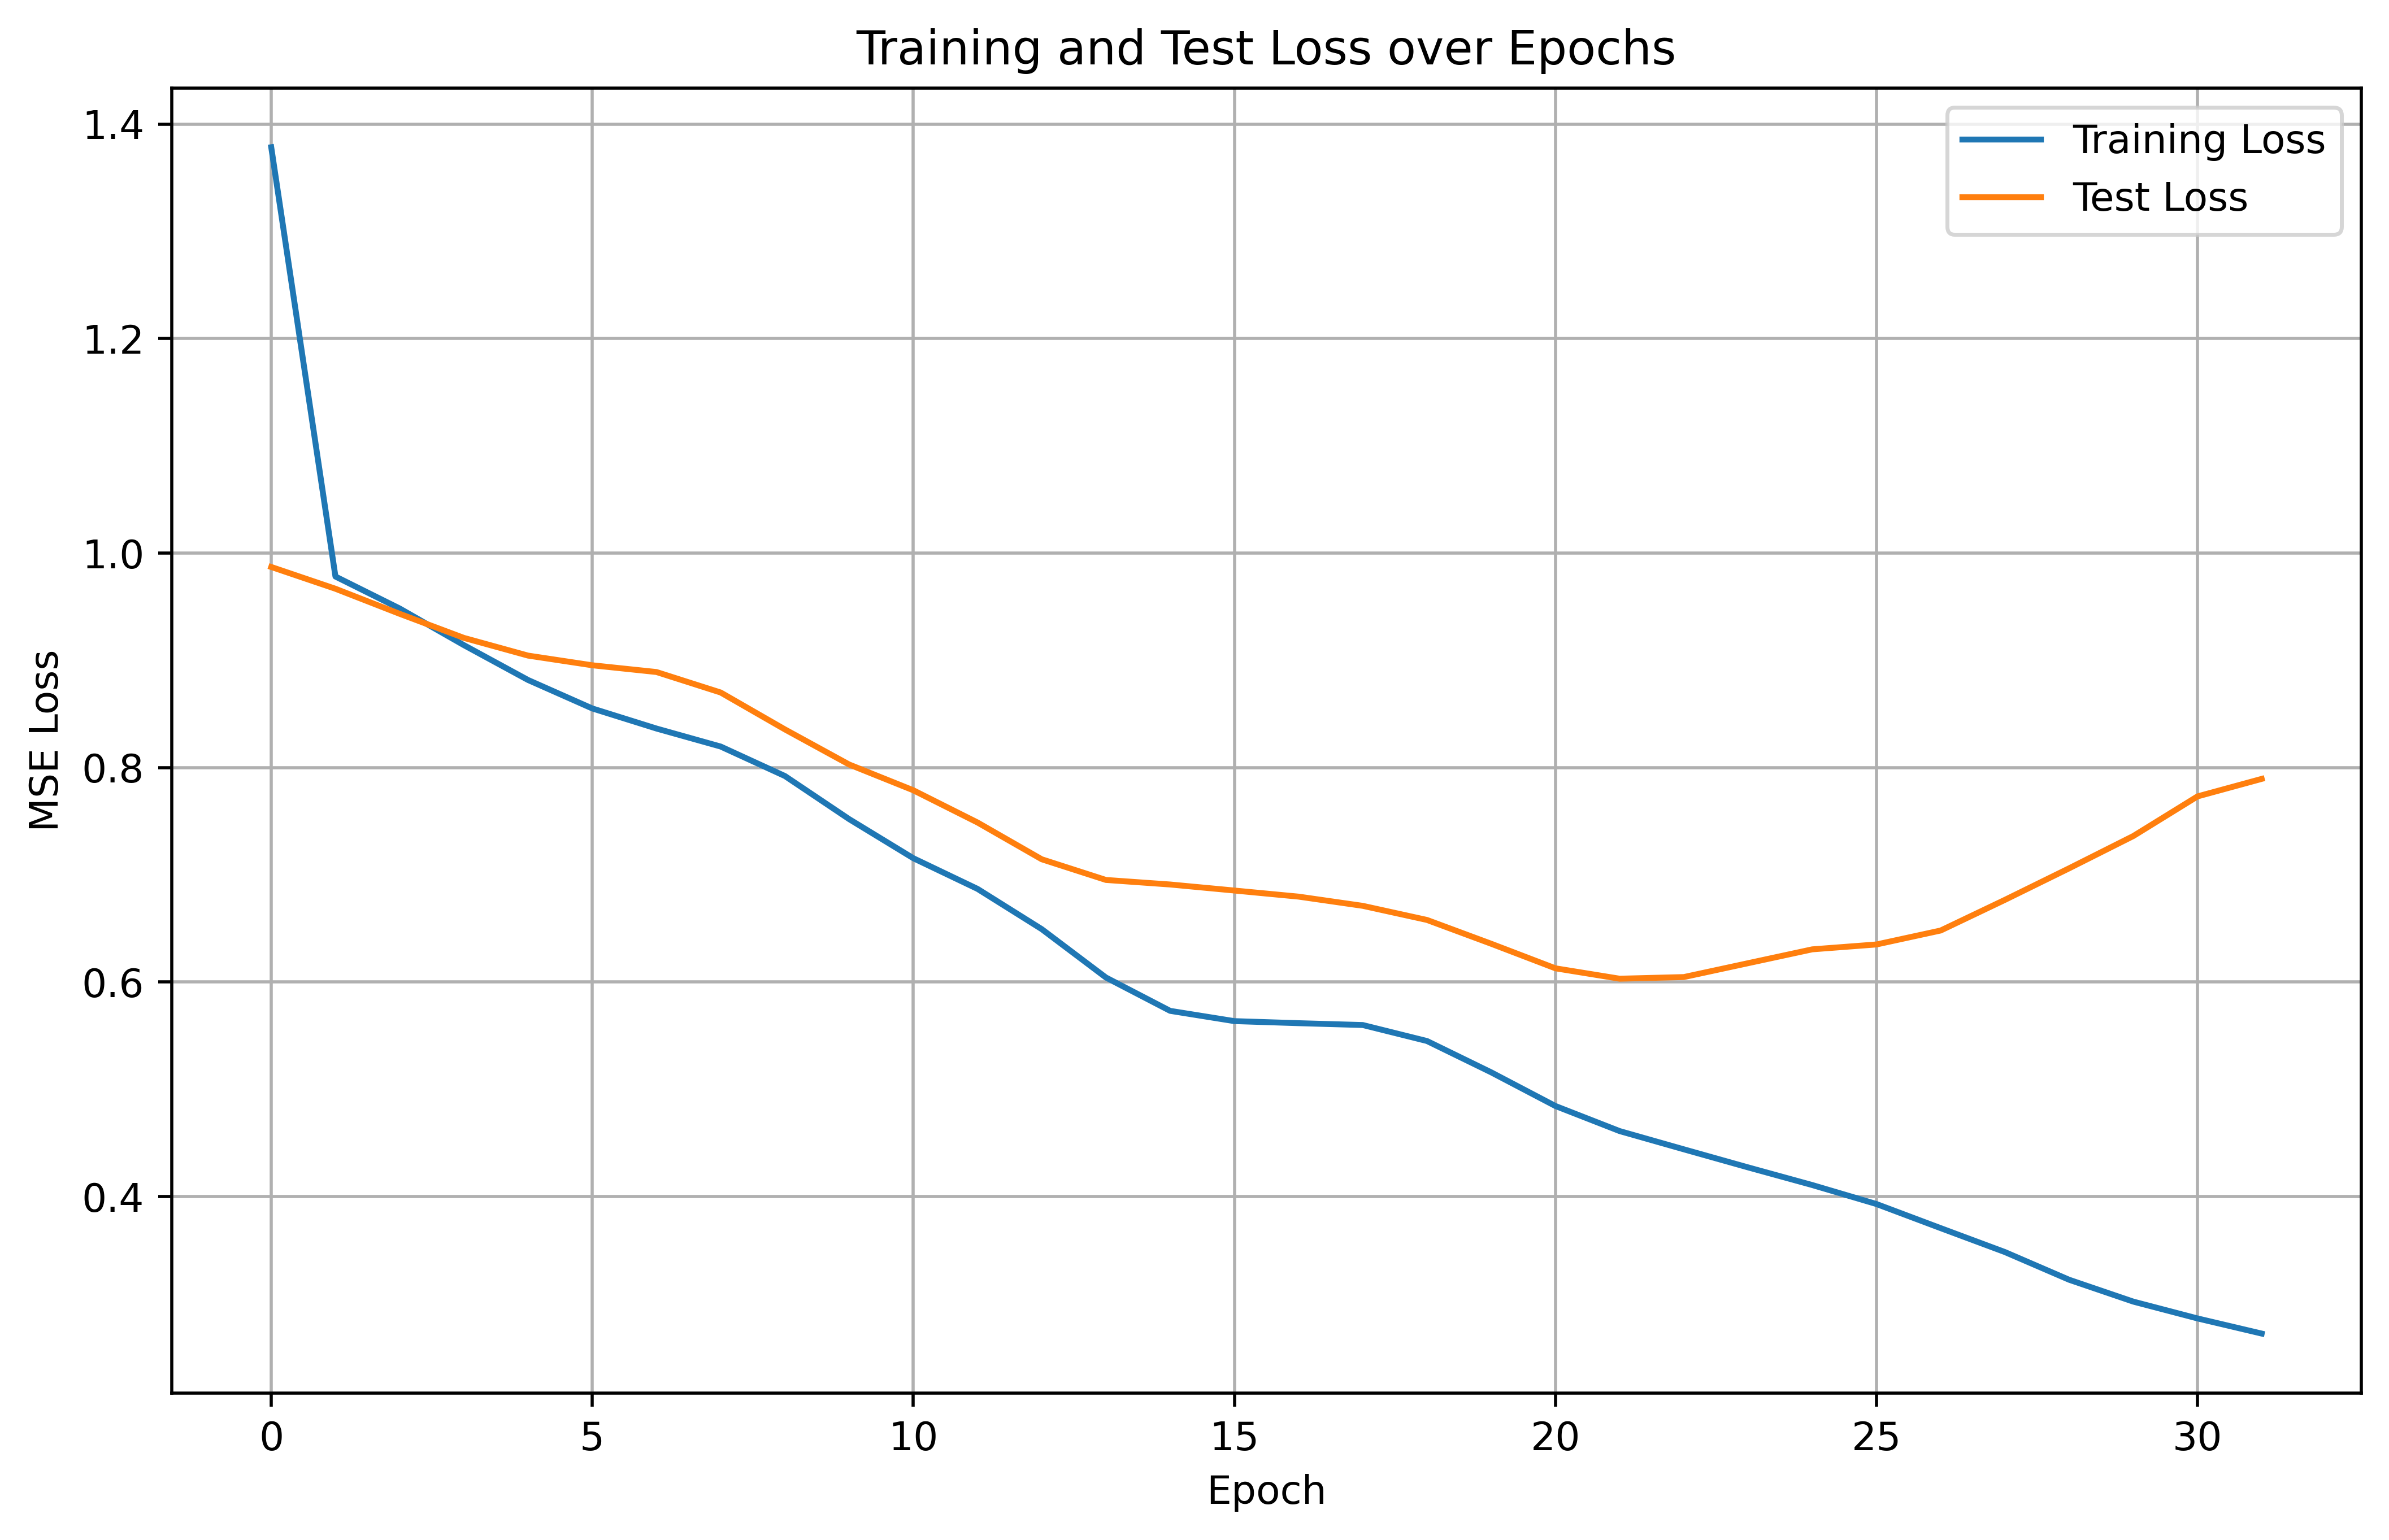

In [ ]:
"""# 6. Final Model Eğitimi
En iyi hiperparametrelerle model eğitilir, early stopping eklendi.
"""

best_params = study.best_trial.params
model = ImprovedGCN(in_channels=2, hidden_channels1=best_params["hidden_channels1"],
                    hidden_channels2=best_params["hidden_channels2"],
                    out_channels=best_params["out_channels"],
                    dropout_rate=best_params["dropout_rate"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.MSELoss()
epochs = best_params["epochs"]

# Test özellikleri
test_features_list = []
for ticker in prices.columns:
    avg_ret_test = test_returns[ticker].mean()
    vol_test = test_returns[ticker].std()
    test_features_list.append([avg_ret_test, vol_test])
test_features = torch.tensor(test_features_list, dtype=torch.float)
test_features = (test_features - test_features.mean(dim=0)) / test_features.std(dim=0)  # Normalizasyon

train_loss_history = []
test_loss_history = []
best_val_loss = float('inf')
patience = 10
trigger = 0

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out_train = model(features.to(device), edge_index.to(device))
    loss_train = criterion(out_train, features.to(device))
    loss_train.backward()
    optimizer.step()
    train_loss_history.append(loss_train.item())

    model.eval()
    with torch.no_grad():
        out_test = model(test_features.to(device), edge_index.to(device))
        loss_test = criterion(out_test, test_features.to(device))
    test_loss_history.append(loss_test.item())

    # Early stopping
    if loss_test.item() < best_val_loss:
        best_val_loss = loss_test.item()
        trigger = 0
    else:
        trigger += 1
    if trigger >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch+1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {loss_train.item():.4f}, Test Loss = {loss_test.item():.4f}")

model.eval()
with torch.no_grad():
    embeddings = model(features.to(device), edge_index.to(device))
embeddings = embeddings.cpu().numpy()
print("Final GCN model eğitildi.")

plt.figure(figsize=(10, 6), dpi=500)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("loss.png", dpi=500, bbox_inches="tight")
plt.show()

# 8. Entegre Portföy Optimizasyonu: Embedding’lerin Kullanılması

Bu hücrede, ImprovedGCN modelinden elde edilen embedding’leri portföy optimizasyonuna entegre ediyoruz.  
Öncelikle, her iki varlık arasındaki kosinüs benzerliğinden bir benzerlik matrisi (S) hesaplanır.  
Ardından, geleneksel kovaryans matrisine ek olarak $ \lambda \cdot S $ ceza terimi eklenir:
  
$
\text{Risk} = w^\top \left(\Sigma + \lambda S\right) w
$

Burada:
- $ \Sigma $: Geleneksel kovaryans matrisi (tarihsel getirilerden hesaplanır),
- $ S $: Embedding benzerlik matrisi,
- $ \lambda $: S matrisinin etkisini kontrol eden ceza ağırlığı.

Ayrıca, portföyde tek bir varlığa maksimum ağırlık sınırı ($ w_i \leq 0.10 $) eklenmiştir.


In [ ]:

norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
S = (embeddings @ embeddings.T) / (norms @ norms.T)
S = (S + 1) / 2
print("Embedding benzerlik matrisi S hesaplandı. Şekli:", S.shape)

expected_returns = np.array([train_returns[ticker].mean() for ticker in prices.columns])
cov_matrix = train_returns.cov().values

# Lambda hassasiyet analizi
lambdas = [0.05, 0.1, 0.2, 0.5]
optimal_weights_dict = {}
for lam in lambdas:
    modified_cov = cov_matrix + lam * S
    w_int = cp.Variable(len(prices.columns))
    target_return = np.percentile(expected_returns, 75)
    max_weight = 0.10
    portfolio_risk = cp.quad_form(w_int, modified_cov)
    problem_int = cp.Problem(cp.Minimize(portfolio_risk),
                             [cp.sum(w_int) == 1, w_int >= 0, w_int <= max_weight,
                              expected_returns @ w_int >= target_return])
    problem_int.solve()
    optimal_weights_int = w_int.value
    optimal_weights_dict[lam] = optimal_weights_int
    print(f"Lambda = {lam} için optimal ağırlıklar:", optimal_weights_int)

optimal_weights_int = optimal_weights_dict[0.1]  # Varsayılan lambda = 0.1

Embedding benzerlik matrisi S hesaplandı. Şekli: (30, 30)
Lambda = 0.05 için optimal ağırlıklar: [ 3.63414163e-02  1.00000000e-01 -1.20297670e-23 -2.14365575e-23
  1.00000000e-01  1.00000000e-01  2.99921595e-02  3.68695608e-24
  3.36664242e-02 -1.01341097e-23  1.00000000e-01  4.49891808e-23
  1.58435017e-24 -1.57670193e-23  3.46901745e-23  3.03381668e-23
 -2.71533471e-23  1.00000000e-01 -1.70678855e-23 -3.08169701e-23
 -1.13624727e-23  3.42205639e-23  6.29056143e-25 -2.41456284e-23
  1.00000000e-01 -1.37619372e-23 -2.37405998e-23  1.00000000e-01
  1.00000000e-01  1.00000000e-01]
Lambda = 0.1 için optimal ağırlıklar: [ 3.50022963e-02  1.00000000e-01 -6.85006493e-23 -1.54700852e-22
  1.00000000e-01  1.00000000e-01  3.74480966e-02 -7.98616650e-23
  2.75496071e-02 -1.46834864e-22  1.00000000e-01  9.56146750e-22
  5.24112499e-23 -5.55253329e-23  4.46160797e-22  3.72949846e-22
 -1.22970849e-22  1.00000000e-01 -5.73230294e-23 -2.37608331e-22
 -1.79804517e-22  5.14449308e-22  7.91306995e-23 -1

# 9. Backtesting: Entegre Modelin Test Verisi Üzerindeki Performansının Değerlendirilmesi

Bu hücrede, entegre modelden elde edilen portföy ağırlıkları kullanılarak test verisi üzerinden portföy getirileri hesaplanır.  
Kümülatif getiri ve yıllık Sharpe oranı gibi metrikler ile modelin performansı değerlendirilir.

**Matematiksel Açıklama:**
- Kümülatif getiri: $ \prod_{t=1}^{T} (1 + r_t) $
- Yıllık Sharpe Oranı: $ \text{Sharpe} = \frac{\mu_p}{\sigma_p} \sqrt{252} $
  (Burada risk-free rate sıfır kabul edilmiştir.)


In [ ]:
"""# 8. Backtesting
Test verisi üzerinden performans hesaplanır, Maximum Drawdown ve Sortino oranı eklendi.
"""

portfolio_returns_int = test_returns.dot(optimal_weights_int)
cumulative_returns_int = (1 + portfolio_returns_int).cumprod()
annual_factor = np.sqrt(252)
model_sharpe_int = portfolio_returns_int.mean() / portfolio_returns_int.std() * annual_factor

# Ek metrikler
def max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

def sortino_ratio(returns, annual_factor):
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std()
    return returns.mean() / downside_std * annual_factor

mdd_int = max_drawdown(portfolio_returns_int)
sortino_int = sortino_ratio(portfolio_returns_int, annual_factor)

print("Hybrid GCN - Cumulative Return:", cumulative_returns_int.iloc[-1])
print("Hybrid GCN Model - Annual Sharpe Ratio:", model_sharpe_int)
print("Hybrid GCN - Maximum Drawdown:", mdd_int)
print("Hybrid GCN - Sortino Ratio:", sortino_int)

Hybrid GCN - Cumulative Return: 1.093751296474871
Hybrid GCN Model - Annual Sharpe Ratio: 1.0046814896708207
Hybrid GCN - Maximum Drawdown: -0.07939736285259771
Hybrid GCN - Sortino Ratio: 1.8342455433406142


# 10. Benchmark Karşılaştırmaları

Bu bölümde, entegre modelin performansını üç farklı benchmark portföy modeliyle karşılaştıracağız:
  
1. **Minimum Varyans Portföyü:**
   - Amaç: $ \min_w w^\top \Sigma w $
   - Kısıtlar: $ \sum_i w_i = 1,\, w_i \geq 0 $
  
2. **Risk Parity Portföyü:**
   - Amaç: Her varlığın portföy riskine eşit katkıda bulunmasını sağlamak.
   - Matematiksel olarak, portföy volatilitesinin her varlık için eşitlenmesi hedeflenir:
     $
     \min_w \sum_{i=1}^n \left( w_i \frac{(\Sigma w)_i}{\sqrt{w^\top \Sigma w}} - \frac{\sqrt{w^\top \Sigma w}}{n} \right)^2
     $
  
3. **Market Cap Weighted Portföy:**
   - Eğer piyasa değeri bilgisi varsa, varlıklar piyasa değerlerine göre ağırlıklandırılır.
   - Burada örnek olması için rastgele market cap değerleri üretip normalize edeceğiz.

Her benchmark model için test verisi üzerinden portföy getirileri, kümülatif getiri ve yıllık Sharpe oranı hesaplanacaktır.


In [ ]:
def min_variance_objective(w, cov_matrix):
    return w.T @ cov_matrix @ w

constraints_mv = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds_mv = tuple((0, 1) for _ in range(len(prices.columns)))
initial_w_mv = np.ones(len(prices.columns)) / len(prices.columns)
result_mv = sco.minimize(min_variance_objective, initial_w_mv, args=(cov_matrix,), bounds=bounds_mv, constraints=constraints_mv)
min_variance_weights = result_mv.x

def risk_parity_objective(w, cov_matrix):
    portfolio_variance = w.T @ cov_matrix @ w
    portfolio_vol = np.sqrt(portfolio_variance)
    marginal_contrib = cov_matrix @ w
    risk_contrib = w * marginal_contrib / portfolio_vol
    target = portfolio_vol / len(w)
    return np.sum((risk_contrib - target) ** 2)

constraints_rp = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds_rp = tuple((0, 1) for _ in range(len(prices.columns)))
initial_w_rp = np.ones(len(prices.columns)) / len(prices.columns)
result_rp = sco.minimize(risk_parity_objective, initial_w_rp, args=(cov_matrix,), bounds=bounds_rp, constraints=constraints_rp)
risk_parity_weights = result_rp.x

np.random.seed(42)
market_caps = np.random.uniform(1e9, 1e10, len(prices.columns))
market_cap_weights = market_caps / np.sum(market_caps)

# 11. Benchmark Performanslarının Hesaplanması ve Karşılaştırılması

Bu hücrede, her benchmark portföyü için test verisi üzerinden portföy getirileri hesaplanır, kümülatif getiri ve yıllık Sharpe oranları belirlenir.  
Elde edilen metrikler, entegre GCN modelimizin sonuçları ile karşılaştırılarak performans farkları incelenir.


In [ ]:

def calculate_metrics(returns, annual_factor):
    sharpe = returns.mean() / returns.std() * annual_factor
    mdd = max_drawdown(returns)
    sortino = sortino_ratio(returns, annual_factor)
    cum_return = (1 + returns).cumprod().iloc[-1]
    return sharpe, mdd, sortino, cum_return

mv_returns = test_returns.dot(min_variance_weights)
rp_returns = test_returns.dot(risk_parity_weights)
mcw_returns = test_returns.dot(market_cap_weights)

mv_sharpe, mv_mdd, mv_sortino, mv_cum = calculate_metrics(mv_returns, annual_factor)
rp_sharpe, rp_mdd, rp_sortino, rp_cum = calculate_metrics(rp_returns, annual_factor)
mcw_sharpe, mcw_mdd, mcw_sortino, mcw_cum = calculate_metrics(mcw_returns, annual_factor)

print("Benchmark Performansları:")
print(f"Min Variance - Sharpe: {mv_sharpe:.4f}, MDD: {mv_mdd:.4f}, Sortino: {mv_sortino:.4f}, Cum Return: {mv_cum:.4f}")
print(f"Risk Parity - Sharpe: {rp_sharpe:.4f}, MDD: {rp_mdd:.4f}, Sortino: {rp_sortino:.4f}, Cum Return: {rp_cum:.4f}")
print(f"Market Cap - Sharpe: {mcw_sharpe:.4f}, MDD: {mcw_mdd:.4f}, Sortino: {mcw_sortino:.4f}, Cum Return: {mcw_cum:.4f}")


Benchmark Performansları:
Min Variance - Sharpe: 0.3830, MDD: -0.0902, Sortino: 0.6835, Cum Return: 1.0260
Risk Parity - Sharpe: 0.3830, MDD: -0.0902, Sortino: 0.6835, Cum Return: 1.0260
Market Cap - Sharpe: 0.3393, MDD: -0.0905, Sortino: 0.5978, Cum Return: 1.0217


# 12. Performansın Görselleştirilmesi

Bu hücrede, entegre GCN modeline ait portföyün ve benchmark portföylerin kümülatif getirileri grafik üzerinde görselleştirilir.  
Grafik, hangi modelin daha yüksek getiriyi ve risk ayarlı performansı sağladığını net olarak gösterir.

**Matematiksel Açıklama:**
- Kümülatif getiri grafiği, zaman serisi boyunca portföyün toplam getirisini gösterir.
- Sharpe oranı, portföyün risk (standart sapma) başına elde ettiği getiriyi yıllık ölçeklendirilmiş olarak ölçer.


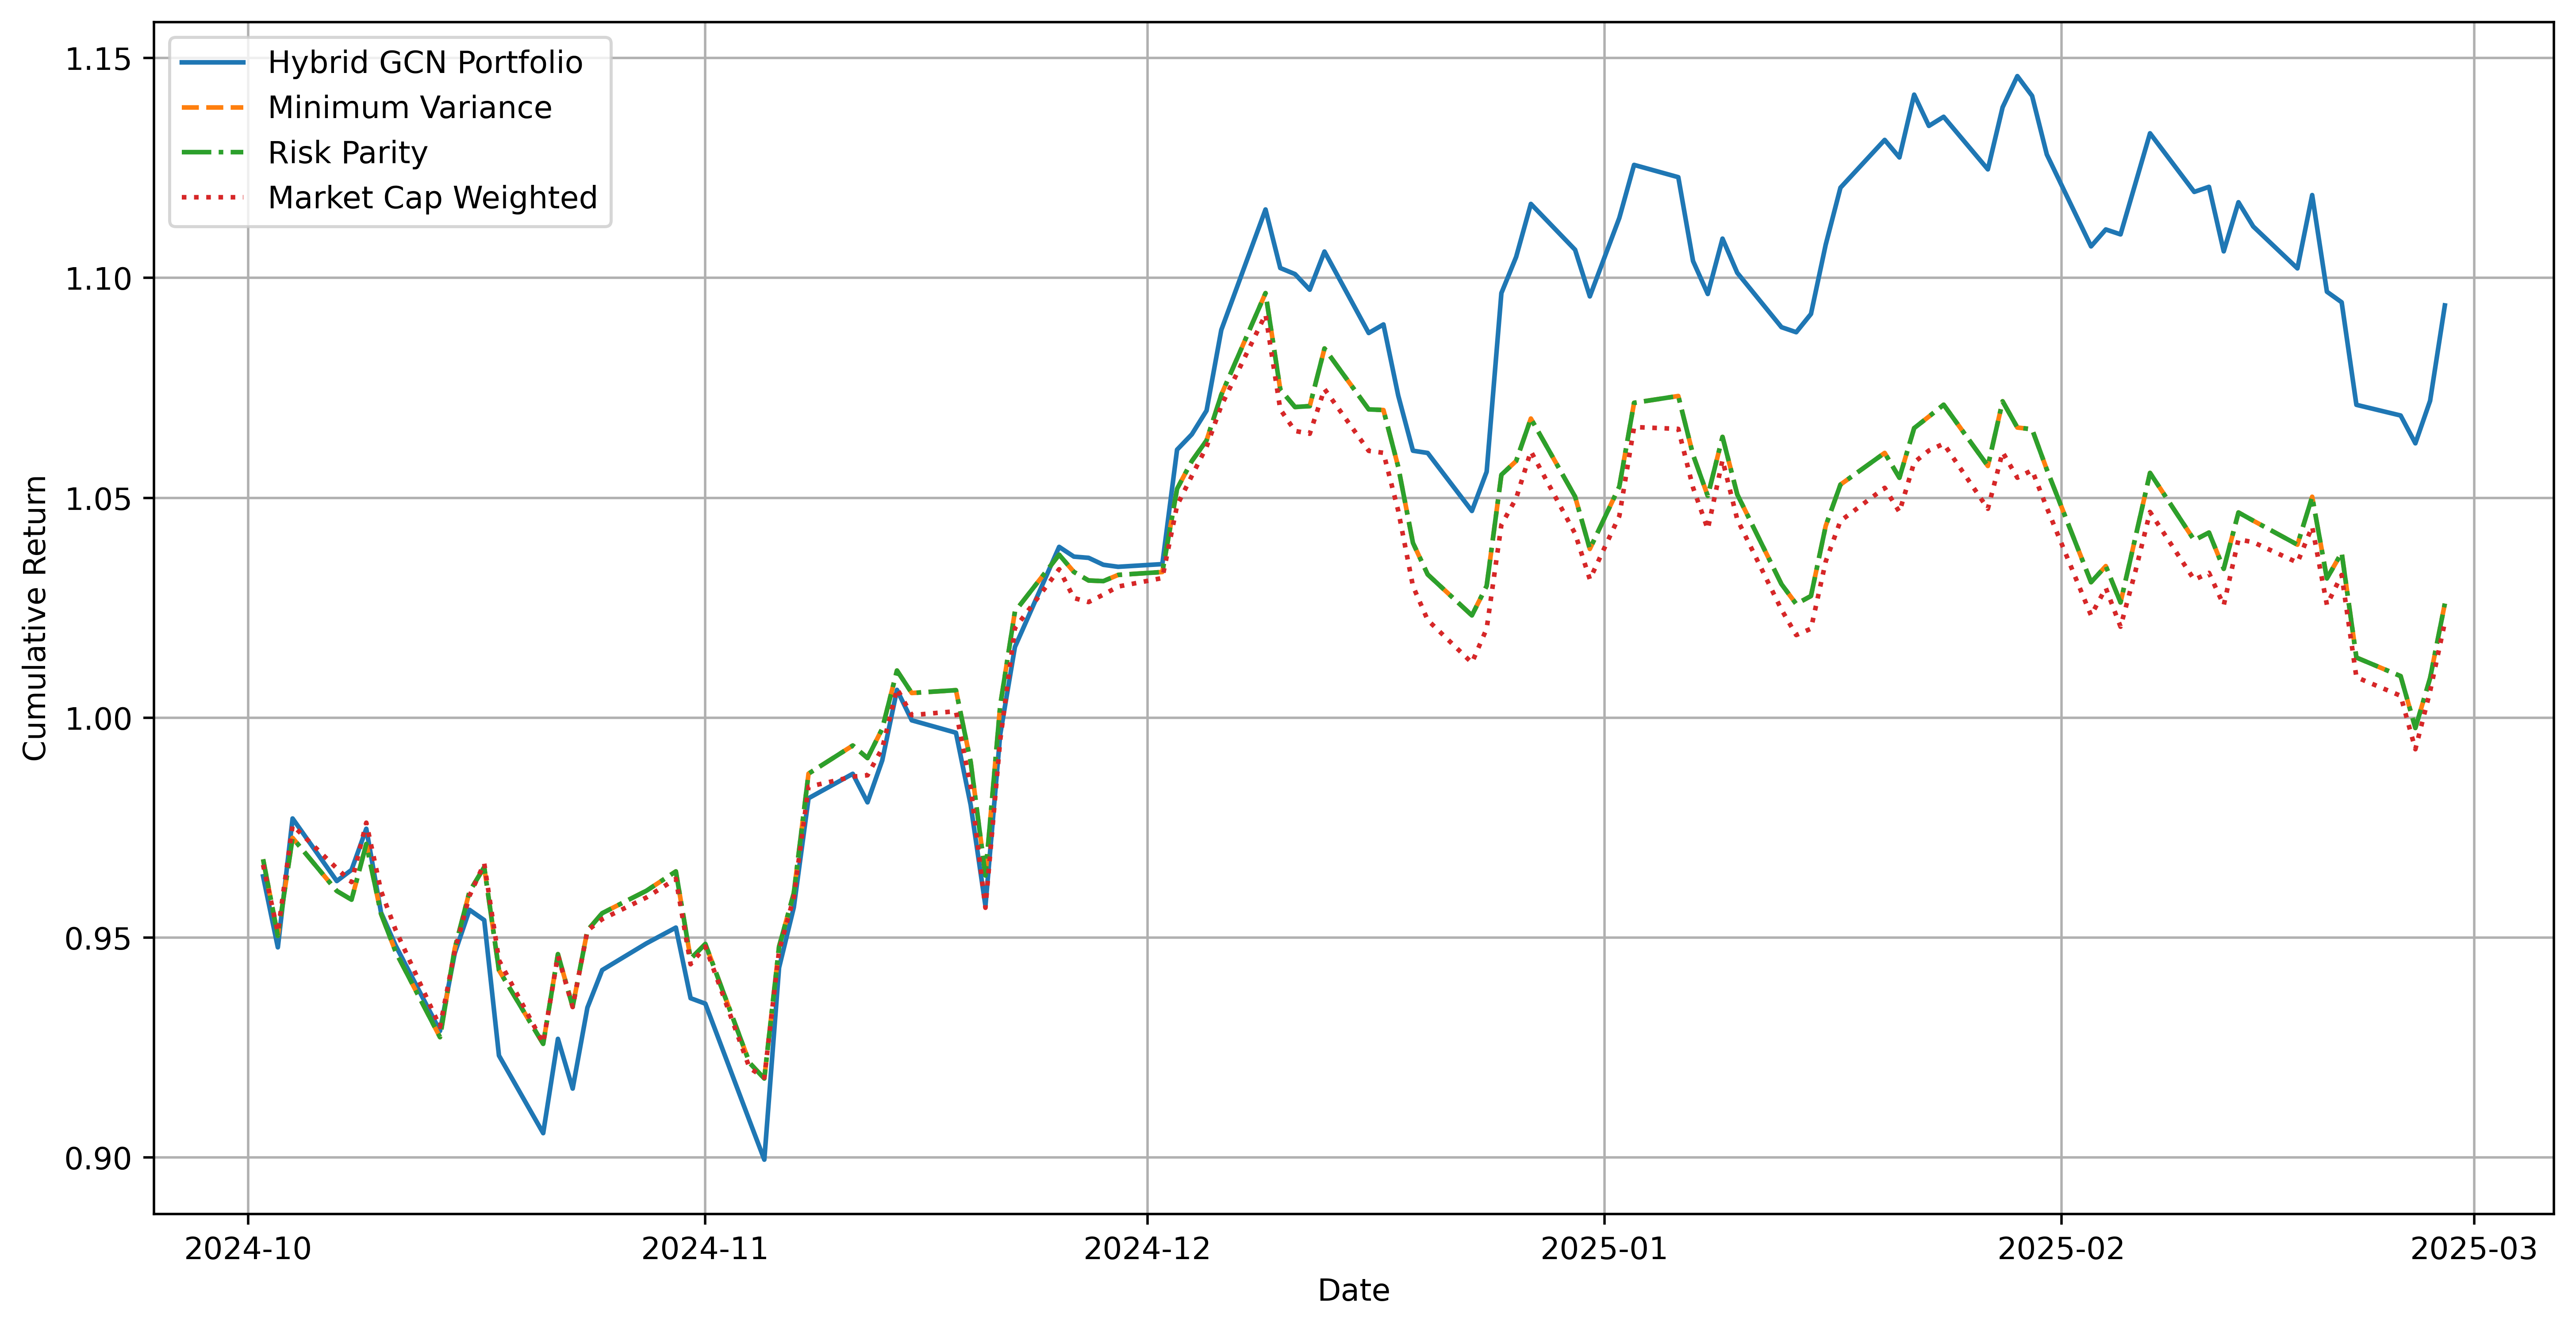

In [ ]:
plt.figure(figsize=(14, 7), dpi=500)
plt.plot(cumulative_returns_int.index, cumulative_returns_int.values, label='Hybrid GCN Portfolio')
plt.plot((1 + mv_returns).cumprod().index, (1 + mv_returns).cumprod().values, label='Minimum Variance', linestyle='--')
plt.plot((1 + rp_returns).cumprod().index, (1 + rp_returns).cumprod().values, label='Risk Parity', linestyle='-.')
plt.plot((1 + mcw_returns).cumprod().index, (1 + mcw_returns).cumprod().values, label='Market Cap Weighted', linestyle=':')
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#plt.title("Test Period Portfolio Performance Comparison")
plt.legend()
plt.grid(True)
plt.savefig("portfolio_performance_comparison.png", dpi=500, bbox_inches="tight")
plt.show()

# 13. Portföy Sharpe Oranı Karşılaştırması Grafiği

Bu hücrede, entegre GCN modelimiz ve benchmark portföy modellerimiz için hesaplanan yıllık Sharpe oranlarını bir bar grafiği üzerinde görselleştiriyoruz.

**Matematiksel Açıklama:**

Sharpe oranı, portföyün risk (standart sapma) başına elde ettiği getiriyi ölçmek için kullanılır ve genellikle aşağıdaki formülle hesaplanır:

$
\text{Sharpe Ratio} = \frac{\mu_p}{\sigma_p} \sqrt{252}
$

Burada:
- $ \mu_p $ portföyün ortalama getirisi,
- $ \sigma_p $ portföyün getirilerinin standart sapması,
- $ 252 $ ise yıllık işlem gün sayısıdır.

Grafikte, her portföy için hesaplanan Sharpe oranları karşılaştırılarak hangi modelin daha iyi risk ayarlı getiri sağladığı incelenir.


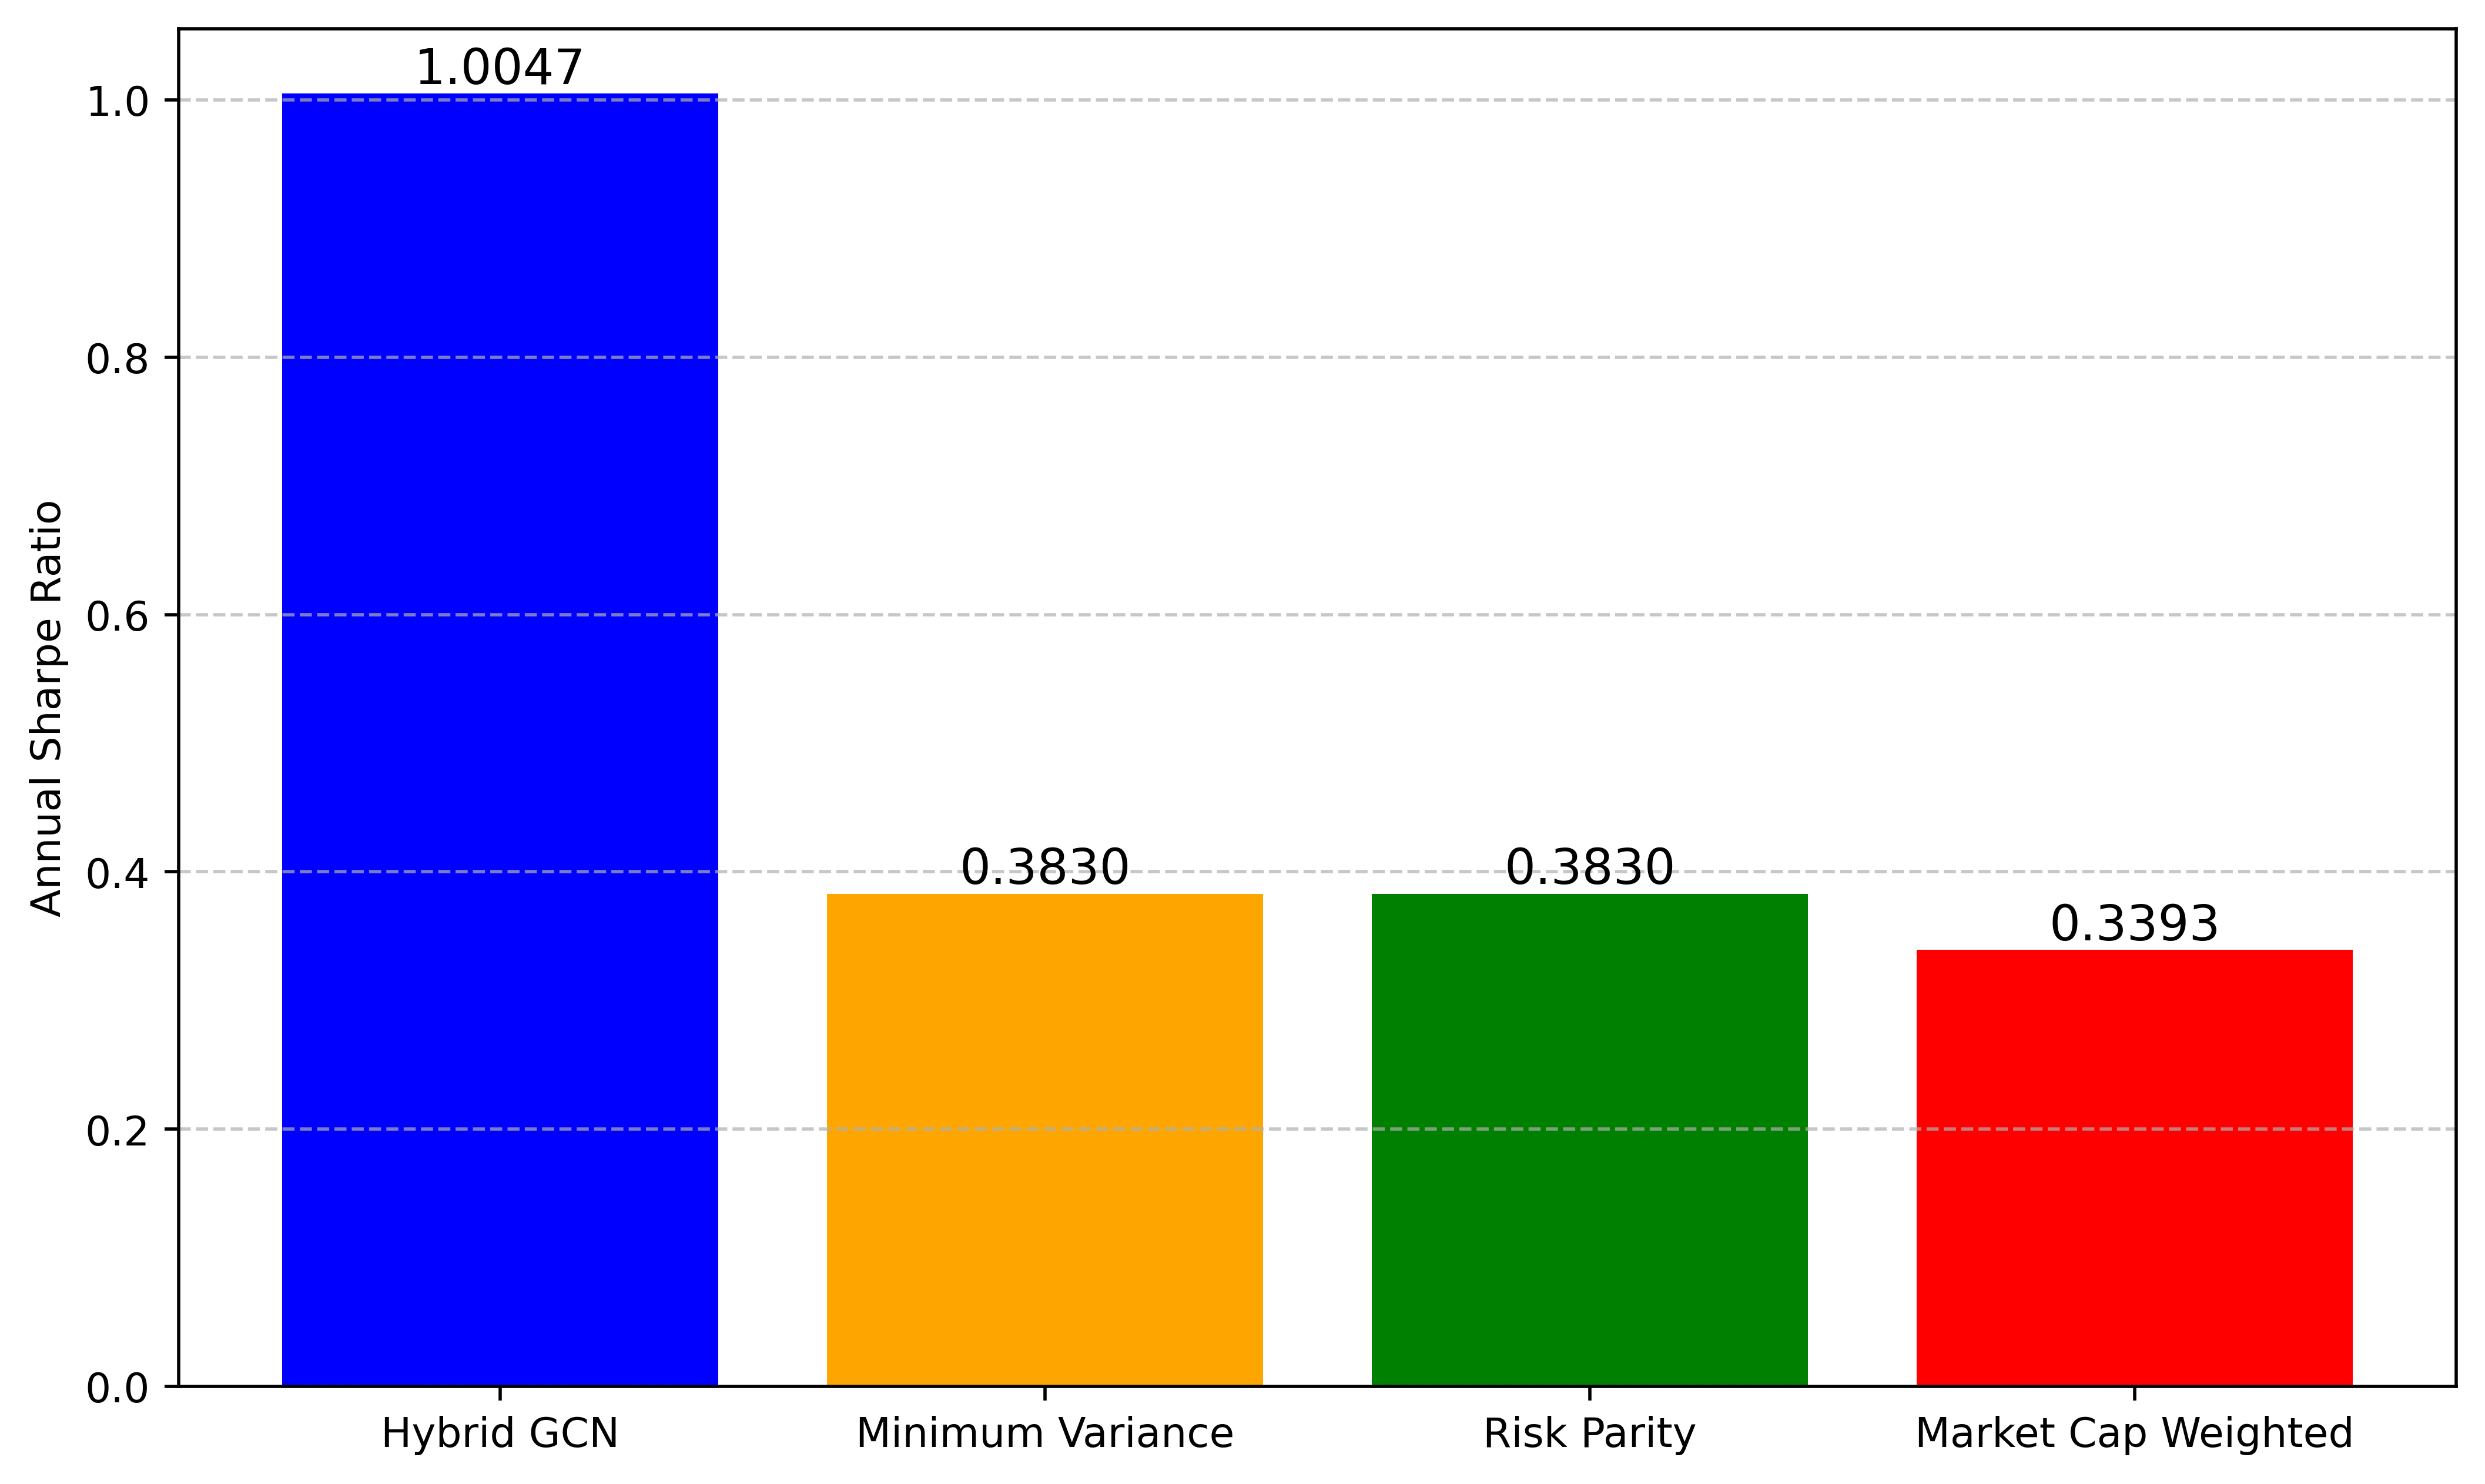

In [ ]:
import matplotlib.pyplot as plt

# Portfolio Sharpe Ratios (values obtained from previous cells)
# model_sharpe_int: Integrated GCN Model Sharpe Ratio
# mv_sharpe: Minimum Variance Portfolio Sharpe Ratio
# rp_sharpe: Risk Parity Portfolio Sharpe Ratio
# mcw_sharpe: Market Cap Weighted Portfolio Sharpe Ratio
labels = ['Hybrid GCN', 'Minimum Variance', 'Risk Parity', 'Market Cap Weighted']
sharpe_values = [model_sharpe_int, mv_sharpe, rp_sharpe, mcw_sharpe]
plt.figure(figsize=(10, 6), dpi=500)
bars = plt.bar(labels, sharpe_values, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Annual Sharpe Ratio')
#plt.title('Portfolio Sharpe Ratio Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom', fontsize=12)
plt.savefig("portfolio_sharpe_comparison.png", dpi=500, bbox_inches="tight")
plt.show()



# 13. Maximum Drawdown (MDD) Karşılaştırması
Portföylerin Maximum Drawdown değerleri bar grafiği ile gösterilir.


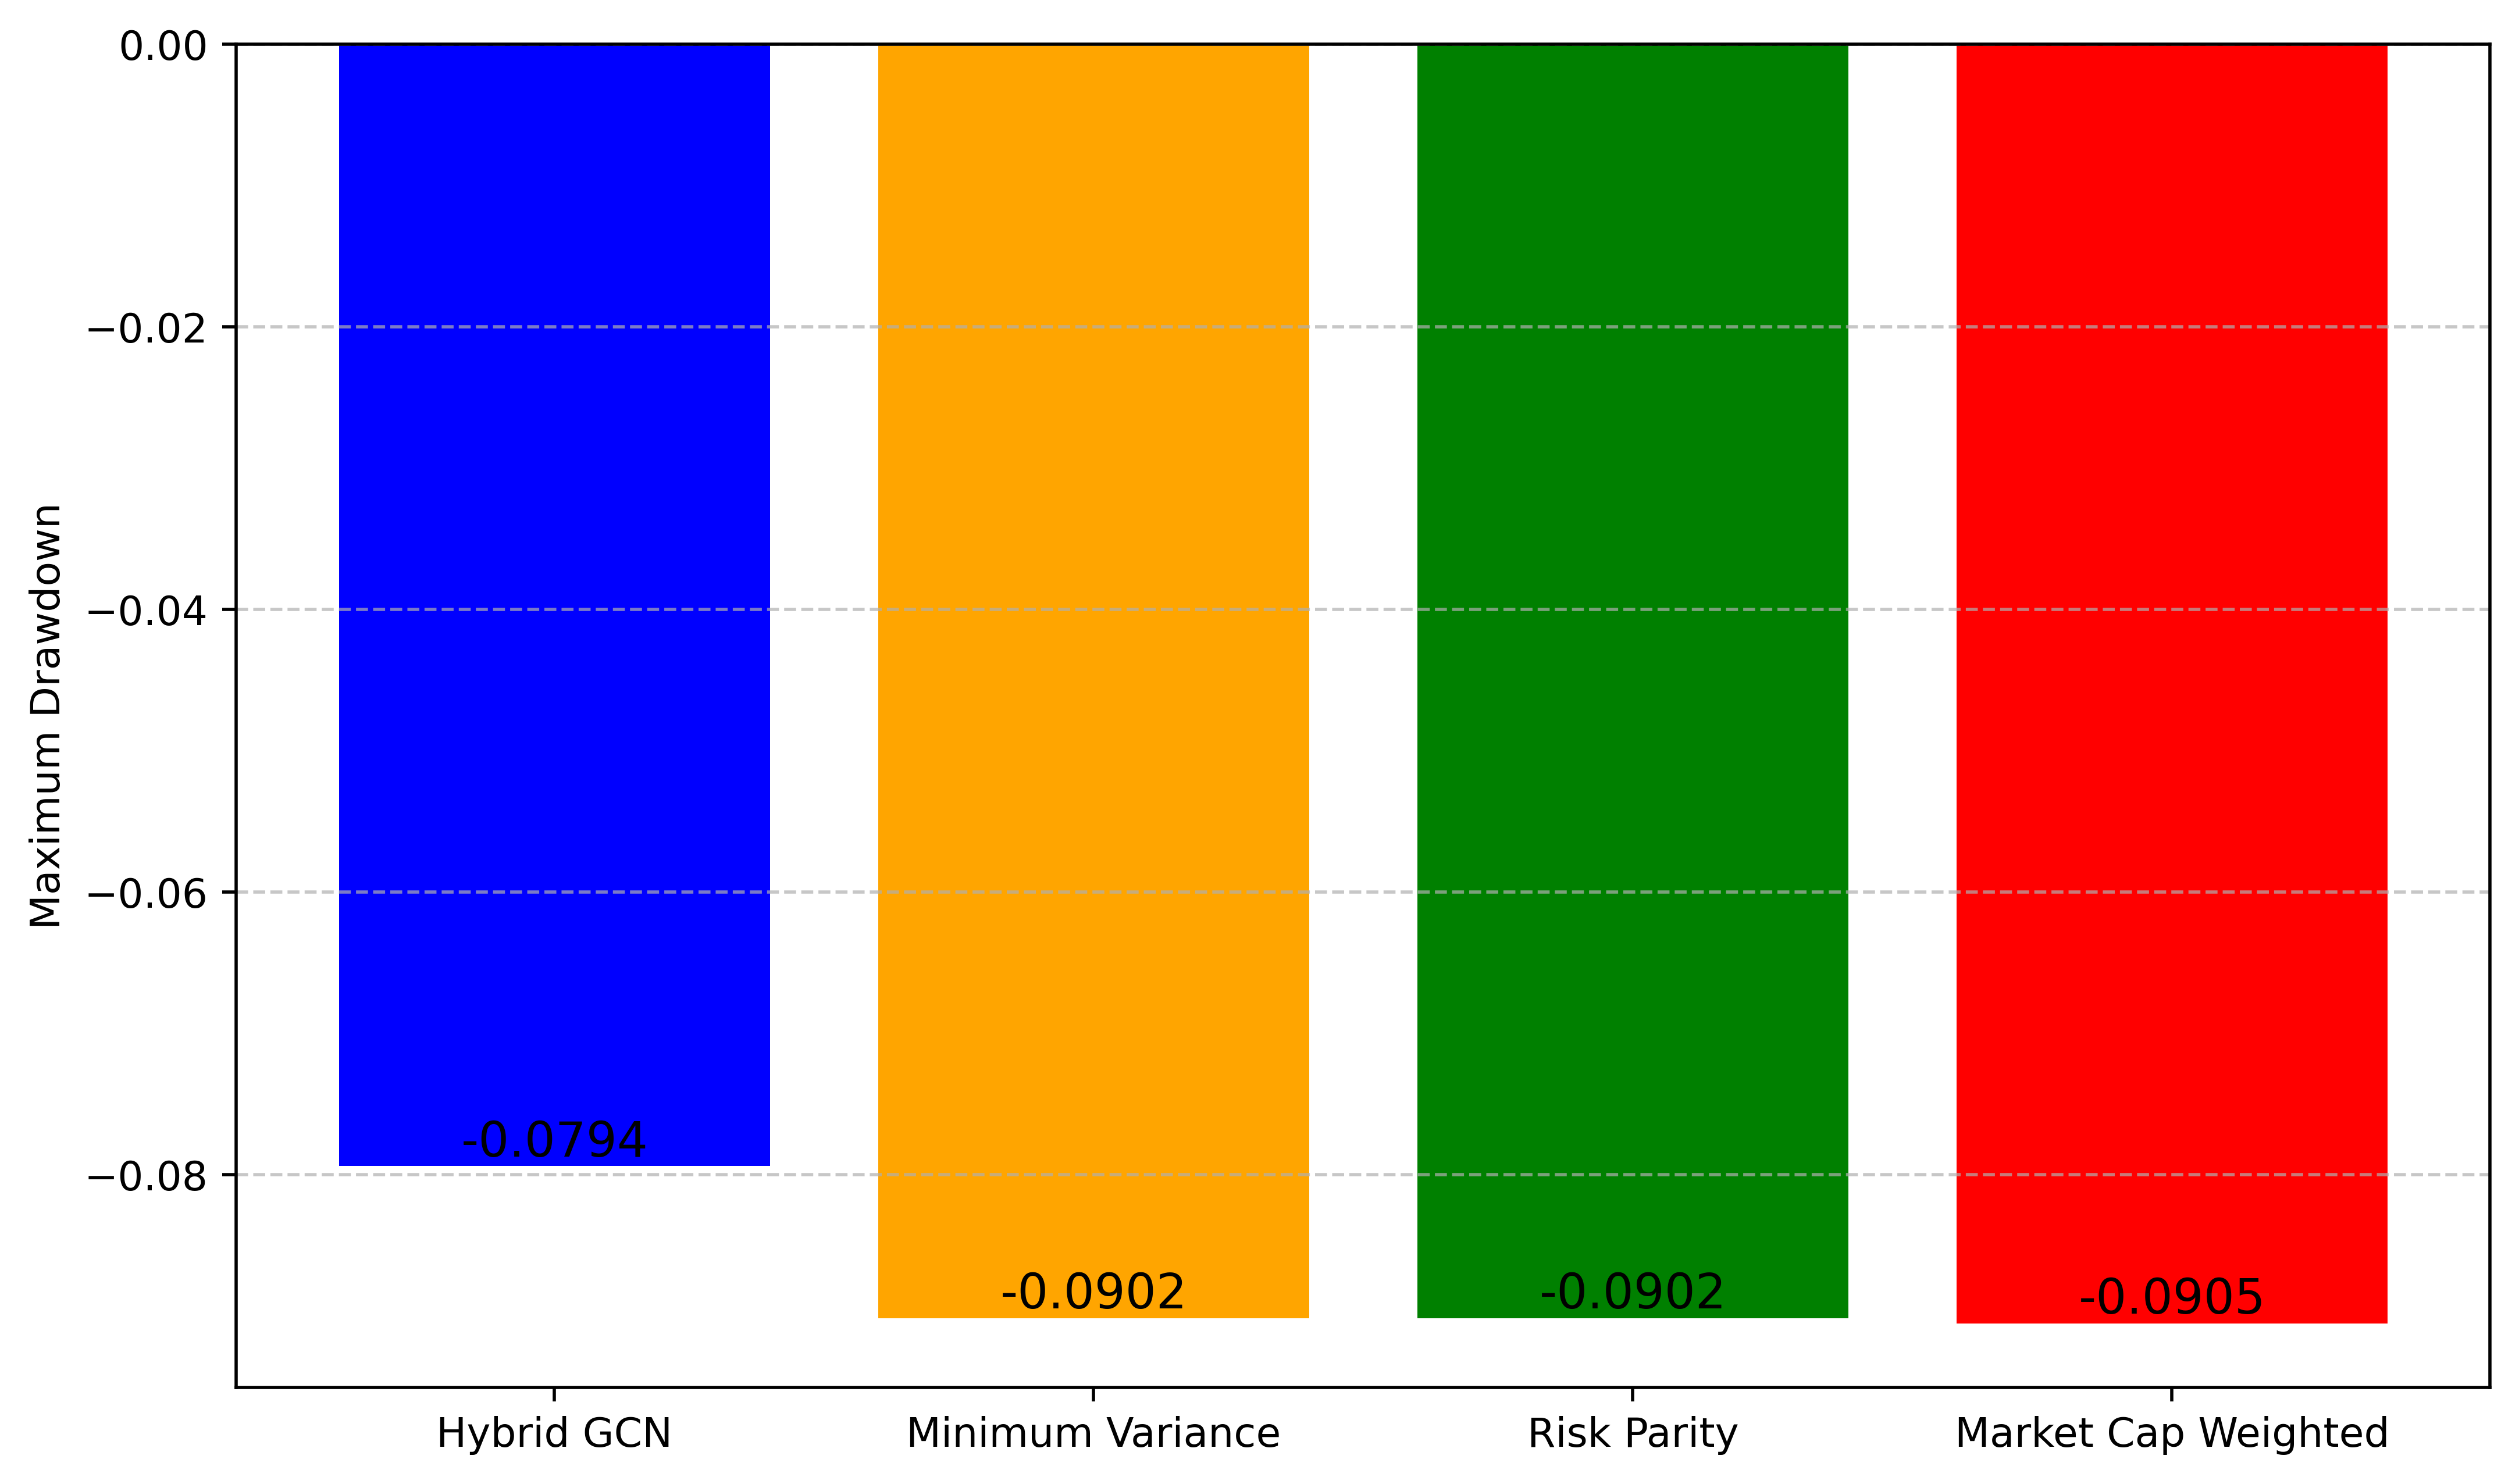

In [ ]:
labels = ['Hybrid GCN', 'Minimum Variance', 'Risk Parity', 'Market Cap Weighted']
mdd_values = [mdd_int, mv_mdd, rp_mdd, mcw_mdd]  # Negatif değerler, daha az kayıp daha iyi
plt.figure(figsize=(10, 6), dpi=500)
bars = plt.bar(labels, mdd_values, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Maximum Drawdown')
#plt.title('Portfolio Maximum Drawdown Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom' if yval < 0 else 'top', fontsize=12)
plt.savefig("portfolio_mdd_comparison.png", dpi=500, bbox_inches="tight")
plt.show()

# 14. Sortino Oranı Karşılaştırması
Portföylerin Sortino oranları bar grafiği ile gösterilir.



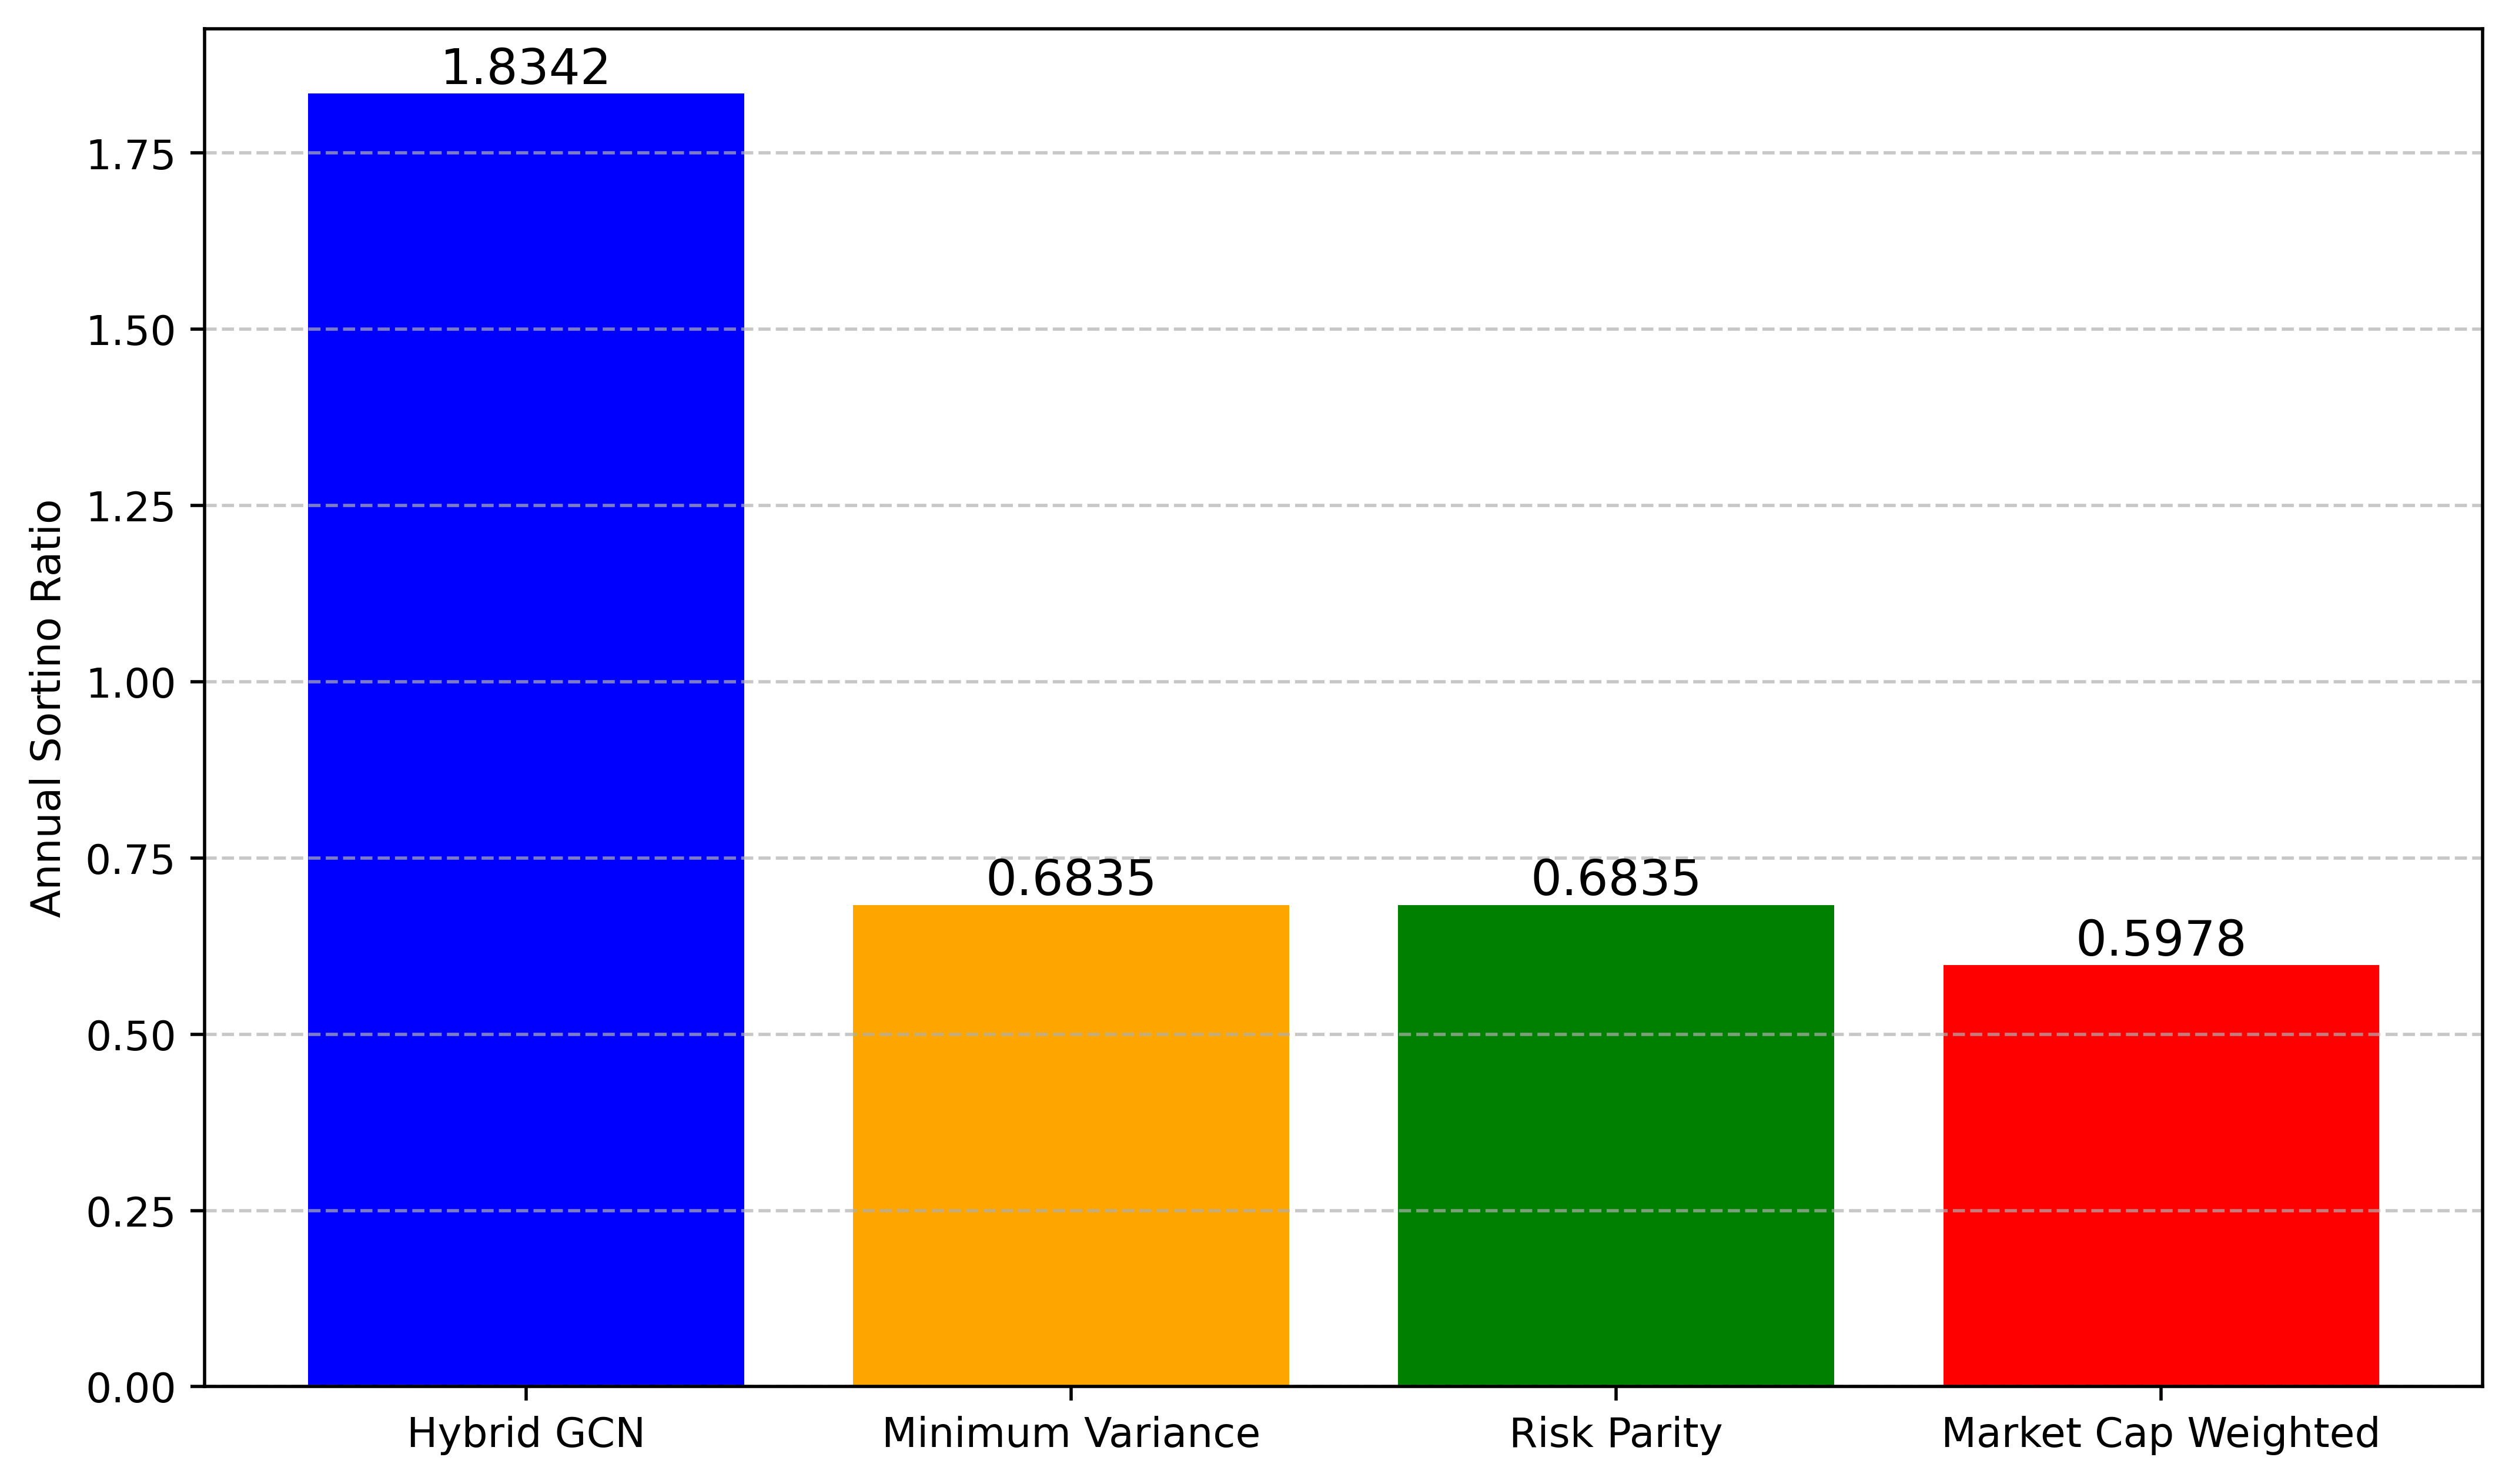

In [ ]:
labels = ['Hybrid GCN', 'Minimum Variance', 'Risk Parity', 'Market Cap Weighted']
sortino_values = [sortino_int, mv_sortino, rp_sortino, mcw_sortino]
plt.figure(figsize=(10, 6), dpi=500)
bars = plt.bar(labels, sortino_values, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Annual Sortino Ratio')
#plt.title('Portfolio Sortino Ratio Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom', fontsize=12)
plt.savefig("portfolio_sortino_comparison.png", dpi=500, bbox_inches="tight")
plt.show()